In [237]:
# Import packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit, train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Get data from my GitHub
df_2020 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2020_NBA_Contracts.csv',index_col = 0)
df_2021 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2021_NBA_Contracts.csv',index_col = 0)
df_2022 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2022_NBA_Contracts.csv',index_col = 0)
print("Imports successful!")

C:\Users\kthay\AppData\Local\Temp\ipykernel_21604\1032042160.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Imports successful!


### Since the salary cap has been rising steadily, a more accurate reflection of a player's salary is the percent of the salary cap they take up 

In [238]:
#Salary Cap data per nba.com
cap2020 = 109100000
cap2021 = 112414000
cap2022 = 123000000
#Add column to each DF represent player salaries as percent of salary cap
df_2020['Cap_Percent'] = df_2020['Avg_Salary']/cap2020
df_2021['Cap_Percent'] = df_2021['Avg_Salary']/cap2021
df_2022['Cap_Percent'] = df_2022['Avg_Salary']/cap2022

In [239]:
# combine last 3 years of contract data
nba_data = pd.concat([df_2020, df_2021, df_2022])
#Some players play multiple positions, however this creates far too many different values in the Position column
#I simplified it so each player is represented by only the position they play the most
nba_data = nba_data.replace({'Pos':{'SF-SG': 'SF', 'SF-PF':'SF', 'PF-C':'PF', 'PF-SF':'PF','SG-PG':'SG','PG-SG':'PG','SG-SF':'SG','C-PF':'C'}})

In [240]:
# Drop columns without any data
nba_data = nba_data.drop(['X', 'X.1'], axis = 1)

In [241]:
# view changes
nba_data.head()

,Player,Years,Full_Salary,Avg_Salary,Pos,Age,Tm,G,GS,MP,...,USG.,OWS,DWS,WS,WS.48,OBPM,DBPM,BPM,VORP,Cap_Percent
1,Alec Burks,1,6000000.0,6000000.0,SF,28,TOT,66,19,26.6,...,23.8,2.5,1.2,3.7,0.101,1.2,-0.7,0.5,1.1,0.054995
2,Alex Len,1,2258000.0,2258000.0,C,26,TOT,55,12,17.6,...,18.1,1.5,1.0,2.5,0.122,-0.5,-0.3,-0.7,0.3,0.020697
3,Anthony Davis,5,189903600.0,37980720.0,PF,26,LAL,62,62,34.4,...,29.3,6.7,4.4,11.1,0.250,5.4,2.6,8.0,5.4,0.348128
4,Aron Baynes,2,14350000.0,7175000.0,C,33,PHO,42,28,22.2,...,21.1,1.3,0.8,2.1,0.107,-0.2,-0.8,-1.0,0.2,0.065765
5,Austin Rivers,3,9975000.0,3325000.0,SG,27,HOU,68,4,23.4,...,15.6,1.2,1.2,2.4,0.072,-2.1,-0.4,-2.5,-0.2,0.030477


In [242]:
# Remove player names and columns with outcome variables (besides cap percent)
refined = nba_data.copy().drop(['Player', 'Years', 'Full_Salary', 'Avg_Salary'], axis =1)

In [243]:
refined.head()

,Pos,Age,Tm,G,GS,MP,FG,FGA,FG.,X3P,...,USG.,OWS,DWS,WS,WS.48,OBPM,DBPM,BPM,VORP,Cap_Percent
1,SF,28,TOT,66,19,26.6,4.9,11.6,0.418,1.8,...,23.8,2.5,1.2,3.7,0.101,1.2,-0.7,0.5,1.1,0.054995
2,C,26,TOT,55,12,17.6,3.2,5.8,0.555,0.3,...,18.1,1.5,1.0,2.5,0.122,-0.5,-0.3,-0.7,0.3,0.020697
3,PF,26,LAL,62,62,34.4,8.9,17.7,0.503,1.2,...,29.3,6.7,4.4,11.1,0.250,5.4,2.6,8.0,5.4,0.348128
4,C,33,PHO,42,28,22.2,4.4,9.1,0.480,1.4,...,21.1,1.3,0.8,2.1,0.107,-0.2,-0.8,-1.0,0.2,0.065765
5,SG,27,HOU,68,4,23.4,3.1,7.4,0.421,1.4,...,15.6,1.2,1.2,2.4,0.072,-2.1,-0.4,-2.5,-0.2,0.030477


In [244]:
# Separate into predictor and outcome variables
X = refined.copy().dropna()
y = X.pop('Cap_Percent')

In [245]:
# Define categorical and numerical predictor variables
cat_features = ["Pos", "Tm"]
num_features = ['Age', 'G',
                'GS', 'MP', 'FG', 'FGA', 'FG.', 'X3P', 'X3PA', 'X3P.', 'X2P', 'X2PA',
                'X2P.', 'eFG.', 'FT', 'FTA', 'FT.', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
                'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS.', 'X3PAr', 'FTr', 'ORB.', 'DRB.',
                'TRB.', 'AST.', 'STL.', 'BLK.', 'TOV.', 'USG.', 'OWS', 'DWS', 'WS',
                'WS.48', 'OBPM', 'DBPM', 'BPM', 'VORP']

# Define preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(), cat_features),
)

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, train_size = .75)

# Apply transformations on all data sets
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [82]


In [246]:
#players = df_combined['Player']

#def group_split(X, y, group, train_size=0.75):
#    splitter = GroupShuffleSplit(train_size=train_size)
 #   train, test = next(splitter.split(X, y, groups=group))
 #   return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])


#X_train, X_valid, y_train, y_valid = group_split(X, y, players)

#X_train = preprocessor.fit_transform(X_train)
#X_valid = preprocessor.transform(X_valid)
#y_train = y_train / 100
#y_valid = y_valid / 100

#input_shape = [X_train.shape[1]]
#print("Input shape: {}".format(input_shape))

In [247]:
# Set up model using ReLU activation and dropouts
model1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate = 0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1)
])

Minimum Validation Loss: 0.0055


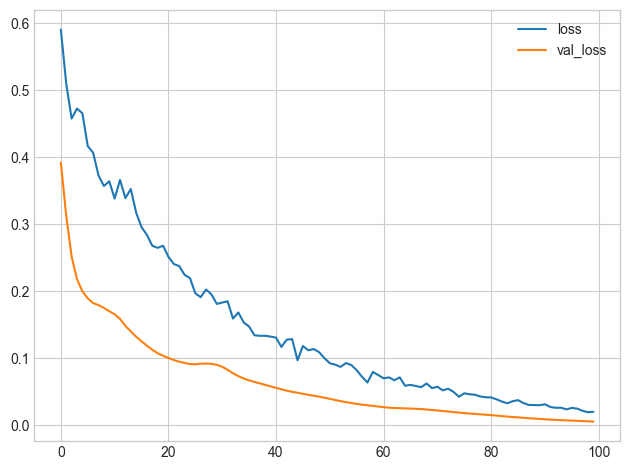

In [248]:
# compile and test model
model1.compile(
    optimizer='adam',
    loss='mae',
)
history = model1.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [249]:
# Set up model using ReLU activation and batch normalization
model2 = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Minimum Validation Loss: 0.0217


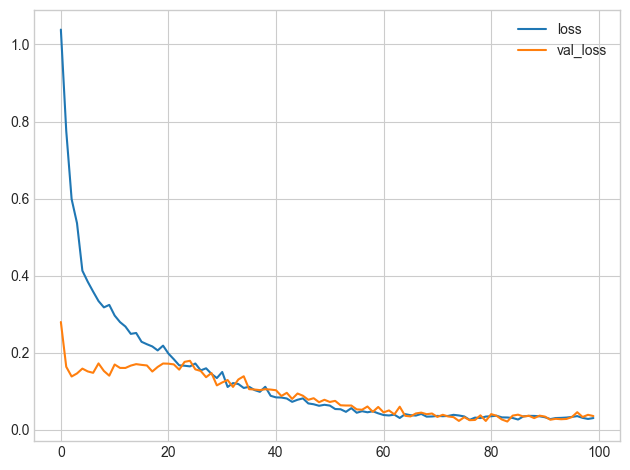

Minimum Validation Loss: 0.0225


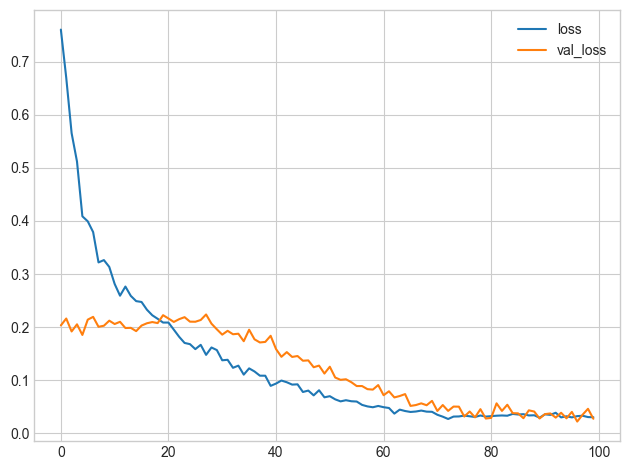

In [250]:
# compile and test model
model2.compile(
    optimizer='sgd',
    loss='mae',
)
history = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=25,
    epochs=100,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))